In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [134]:
df = pd.read_csv('family_financial_and_transactions_data.csv')

In [135]:
df.head

<bound method NDFrame.head of       Family ID       Member ID Transaction Date       Category  Amount  \
0        FAM001  FAM001_Member1       07-10-2024         Travel  409.12   
1        FAM001  FAM001_Member1       16-10-2024         Travel  270.91   
2        FAM001  FAM001_Member1       17-10-2024      Groceries   91.10   
3        FAM001  FAM001_Member1       25-10-2024     Healthcare  198.23   
4        FAM001  FAM001_Member1       25-10-2024      Education  206.42   
...         ...             ...              ...            ...     ...   
16301    FAM200  FAM200_Member6       10-10-2024      Groceries   79.99   
16302    FAM200  FAM200_Member6       22-10-2024      Education  228.39   
16303    FAM200  FAM200_Member6       29-10-2024         Travel  258.63   
16304    FAM200  FAM200_Member6       26-10-2024         Travel  467.46   
16305    FAM200  FAM200_Member6       27-10-2024  Entertainment  475.34   

       Income  Savings  Monthly Expenses  Loan Payments  Credit Card 

In [136]:
df.columns

Index(['Family ID', 'Member ID', 'Transaction Date', 'Category', 'Amount',
       'Income', 'Savings', 'Monthly Expenses', 'Loan Payments',
       'Credit Card Spending', 'Dependents', 'Financial Goals Met (%)'],
      dtype='object')

In [137]:
df.describe()

,Amount,Income,Savings,Monthly Expenses,Loan Payments,Credit Card Spending,Dependents,Financial Goals Met (%)
count,16306.000000,16306.000000,16306.000000,16306.000000,16306.000000,16306.000000,16306.000000,16306.000000
mean,256.368534,90340.503925,24473.998038,3948.522384,2529.978965,1782.880535,3.201521,59.418006
std,141.153813,34740.834136,14828.955695,1689.987801,1384.105561,716.595101,1.468880,23.444304
min,10.030000,30851.000000,1037.000000,1013.000000,3.000000,510.000000,0.000000,21.000000
25%,134.820000,59871.000000,11016.000000,2582.000000,1390.000000,1221.000000,2.000000,37.000000
50%,256.055000,90142.000000,25504.000000,3721.000000,2548.000000,1705.000000,3.000000,58.000000
75%,379.240000,119733.000000,37422.000000,5450.000000,3724.000000,2422.000000,4.000000,79.000000
max,499.910000,149871.000000,49217.000000,6968.000000,4974.000000,2999.000000,5.000000,100.000000


## Spending distribution by category

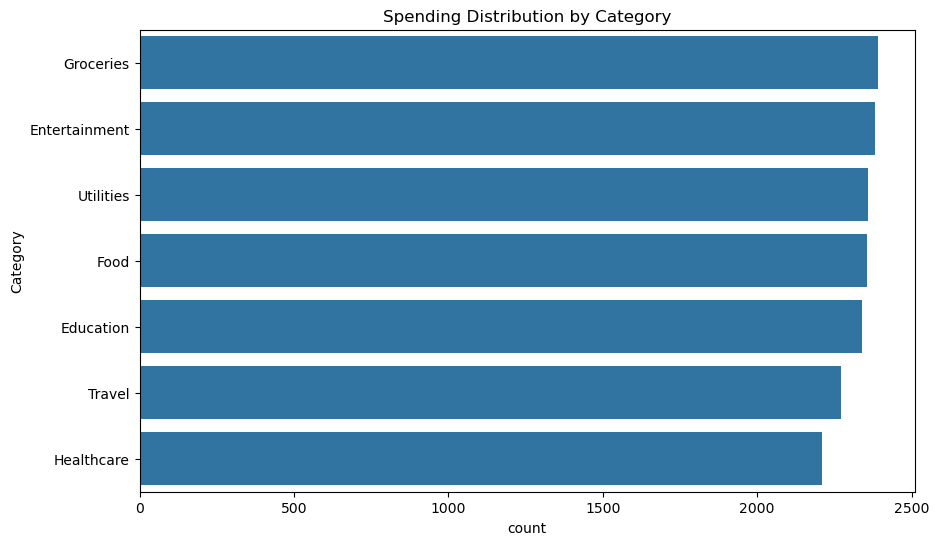

In [139]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index)
plt.title("Spending Distribution by Category")
plt.show()

In [140]:
# Filter the DataFrame to include only numerical columns

In [141]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

In [142]:
# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

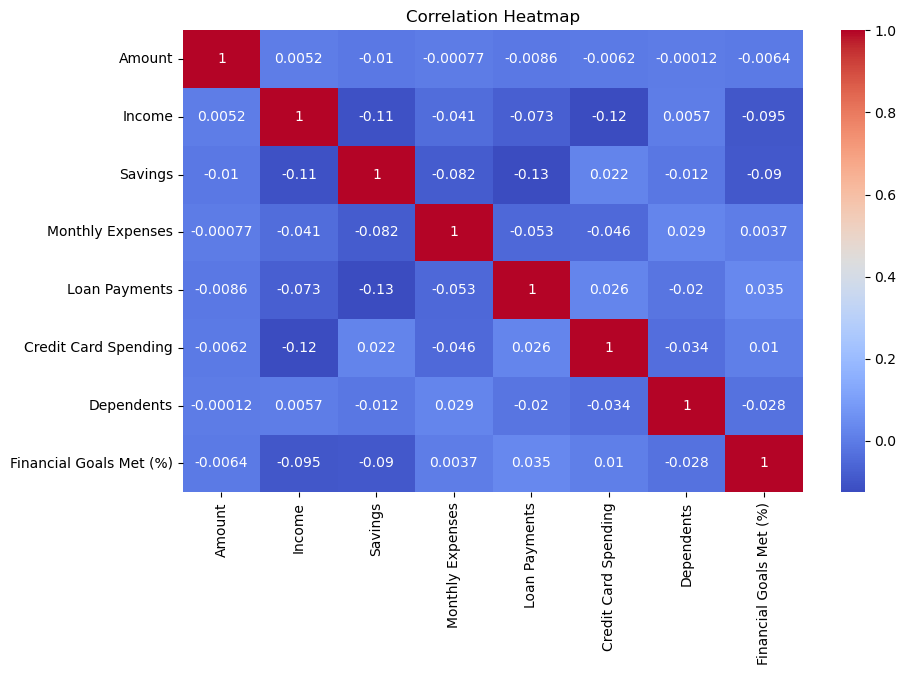

In [143]:
# plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [144]:
# Grouping by Family ID to analyze total spending
family_spending = df.groupby('Family ID').agg({
    'Amount': 'sum',  # Total spending
    'Savings': 'mean',  # Average savings per family
    'Income': 'mean',  # Average income per family
    'Monthly Expenses': 'mean'  # Average monthly expenses
}).reset_index()

In [145]:
# Adding a spending-to-income ratio
family_spending['Spending_to_Income'] = family_spending['Amount'] / family_spending['Income']

print(family_spending.head())

  Family ID    Amount  Savings    Income  Monthly Expenses  Spending_to_Income
0    FAM001  23188.90  20234.0  113810.0            5781.0            0.203751
1    FAM002  22309.71  29492.0   44592.0            5630.0            0.500307
2    FAM003  11220.34  11365.0   33278.0            5282.0            0.337170
3    FAM004  23483.10  30735.0  127196.0            3591.0            0.184621
4    FAM005  40246.21   1212.0   66048.0            3136.0            0.609348


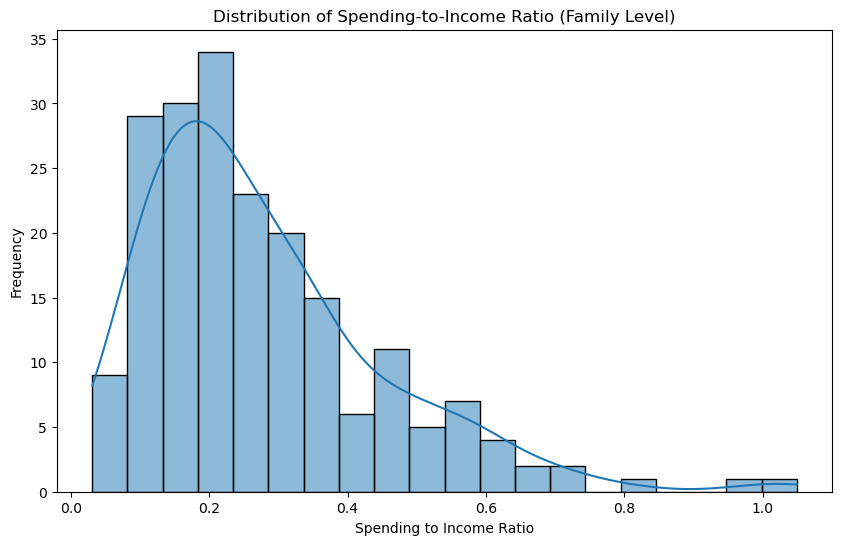

In [146]:
# Ploting spending-to-income ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(family_spending['Spending_to_Income'], kde=True, bins=20)
plt.title("Distribution of Spending-to-Income Ratio (Family Level)")
plt.xlabel("Spending to Income Ratio")
plt.ylabel("Frequency")
plt.show()

In [147]:
# Member level spending pattern
member_spending = df.groupby('Member ID').agg({
    'Amount': 'sum',
    'Category': 'nunique',  # Number of unique spending categories
}).reset_index()

# Rename columns for clarity
member_spending.rename(columns={'Amount': 'Total Spending', 'Category': 'Unique Categories'}, inplace=True)

print(member_spending.head())

        Member ID  Total Spending  Unique Categories
0  FAM001_Member1         6521.20                  7
1  FAM001_Member2         7084.83                  7
2  FAM001_Member3         2119.41                  6
3  FAM001_Member4         7463.46                  6
4  FAM002_Member1         3082.90                  7


# visualizing member level trends

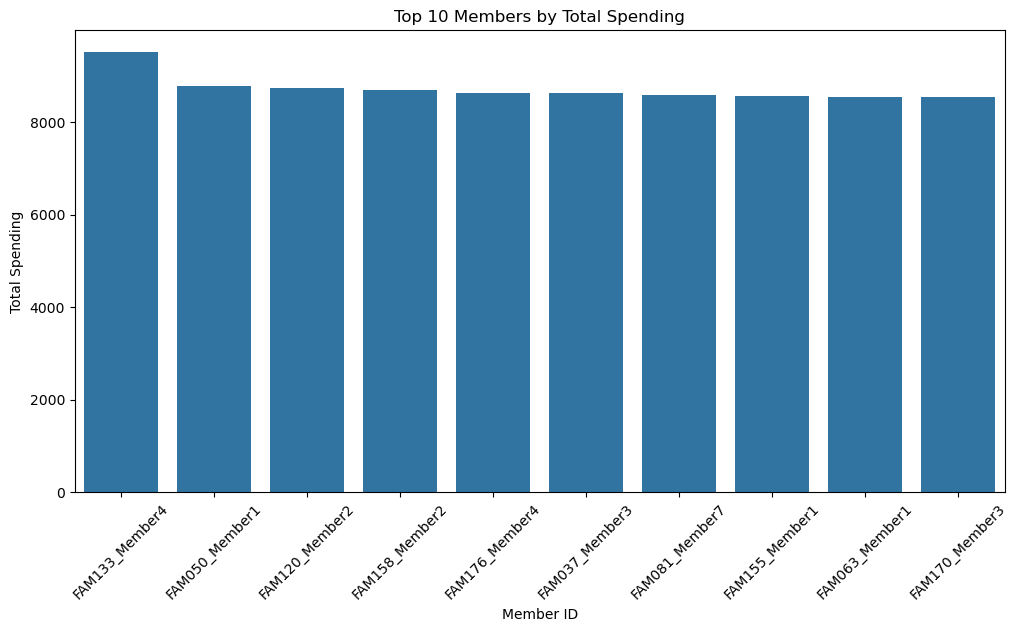

In [149]:
# Bar plot for top 10 members by spending
top_members = member_spending.sort_values(by='Total Spending', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Member ID', y='Total Spending', data=top_members)
plt.title("Top 10 Members by Total Spending")
plt.xticks(rotation=45)
plt.ylabel("Total Spending")
plt.xlabel("Member ID")
plt.show()

# Financial scoring Model

In [151]:
# Define the scoring function
def calculate_financial_score(row):
    # Normalize each factor to a 0-1 scale and apply weights
    savings_score = min(row['Savings'] / row['Income'], 1) * 30  # Weight: 30
    expenses_score = (1 - min(row['Monthly Expenses'] / row['Income'], 1)) * 25  # Weight: 25
    loan_score = (1 - min(row['Loan Payments'] / row['Income'], 1)) * 20  # Weight: 20
    cc_score = (1 - min(row['Credit Card Spending'] / row['Income'], 1)) * 15  # Weight: 15
    goals_score = (row['Financial Goals Met (%)'] / 100) * 10  # Weight: 10

    # Calculating total score (out of 100)
    total_score = savings_score + expenses_score + loan_score + cc_score + goals_score
    return round(total_score, 2)

# Applying the scoring model
df['Financial Score'] = df.apply(calculate_financial_score, axis=1)
# Check results
print(df[['Family ID', 'Member ID', 'Financial Score']].head())

  Family ID       Member ID  Financial Score
0    FAM001  FAM001_Member1            70.05
1    FAM001  FAM001_Member1            70.05
2    FAM001  FAM001_Member1            70.05
3    FAM001  FAM001_Member1            70.05
4    FAM001  FAM001_Member1            70.05


# Aggregate by Family ID

In [153]:
family_scores = df.groupby('Family ID').agg({
    'Income': 'sum',
    'Savings': 'sum',
    'Monthly Expenses': 'sum',
    'Loan Payments': 'sum',
    'Credit Card Spending': 'sum',
    'Financial Goals Met (%)': 'mean'  # Average across family members
}).reset_index()

# Applying the scoring model to family-level aggregated data
family_scores['Financial Score'] = family_scores.apply(calculate_financial_score, axis=1)

print(family_scores.head())

  Family ID    Income  Savings  Monthly Expenses  Loan Payments  \
0    FAM001  10584330  1881762            537633         225246   
1    FAM002   3924096  2595296            495440         399608   
2    FAM003   1564066   534155            248254          48974   
3    FAM004  12083620  2919825            341145         149245   
4    FAM005  10897920   199980            517440         568260   

   Credit Card Spending  Financial Goals Met (%)  Financial Score  
0                275187                     68.0            70.05  
1                 87560                     60.0            80.31  
2                132446                    100.0            74.38  
3                 63460                     82.0            74.42  
4                317130                     89.0            66.78  


# Aggregate by Member ID

In [155]:
member_scores = df.groupby('Member ID').agg({
    'Income': 'mean',
    'Savings': 'mean',
    'Monthly Expenses': 'mean',
    'Loan Payments': 'mean',
    'Credit Card Spending': 'mean',
    'Financial Goals Met (%)': 'mean'
}).reset_index()

# Applying the scoring model to member-level aggregated data
member_scores['Financial Score'] = member_scores.apply(calculate_financial_score, axis=1)

print(member_scores.head())

        Member ID    Income  Savings  Monthly Expenses  Loan Payments  \
0  FAM001_Member1  113810.0  20234.0            5781.0         2422.0   
1  FAM001_Member2  113810.0  20234.0            5781.0         2422.0   
2  FAM001_Member3  113810.0  20234.0            5781.0         2422.0   
3  FAM001_Member4  113810.0  20234.0            5781.0         2422.0   
4  FAM002_Member1   44592.0  29492.0            5630.0         4541.0   

   Credit Card Spending  Financial Goals Met (%)  Financial Score  
0                2959.0                     68.0            70.05  
1                2959.0                     68.0            70.05  
2                2959.0                     68.0            70.05  
3                2959.0                     68.0            70.05  
4                 995.0                     60.0            80.31  


# Checking Unique Families or Members

In [157]:
print(df[['Family ID', 'Member ID', 'Financial Score']].drop_duplicates(subset=['Family ID']).head())

    Family ID       Member ID  Financial Score
0      FAM001  FAM001_Member1            70.05
93     FAM002  FAM002_Member1            80.31
181    FAM003  FAM003_Member1            74.38
228    FAM004  FAM004_Member1            74.42
323    FAM005  FAM005_Member1            66.78


# Visualizing Financial Scores

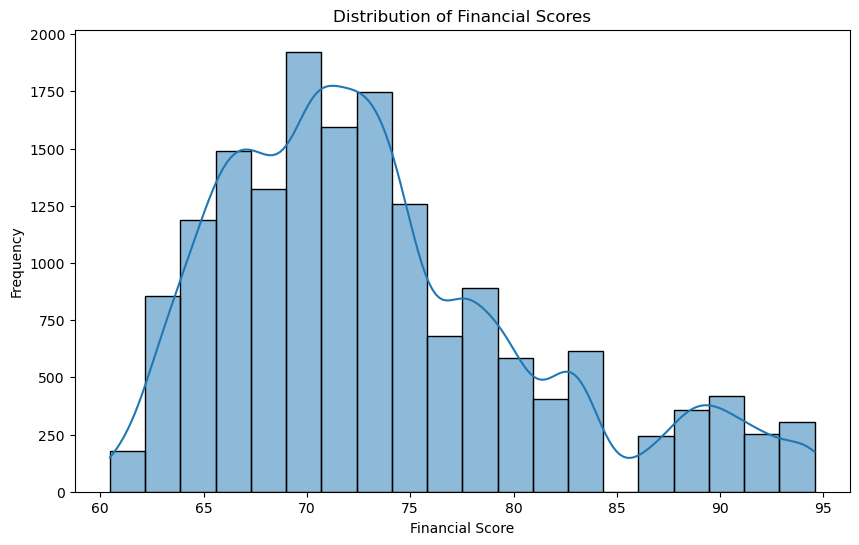

In [159]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Financial Score'], kde=True, bins=20)
plt.title("Distribution of Financial Scores")
plt.xlabel("Financial Score")
plt.ylabel("Frequency")
plt.show()

In [160]:
family_scores_sorted = family_scores.sort_values(by='Financial Score', ascending=False)

 # Bar plot for family scores


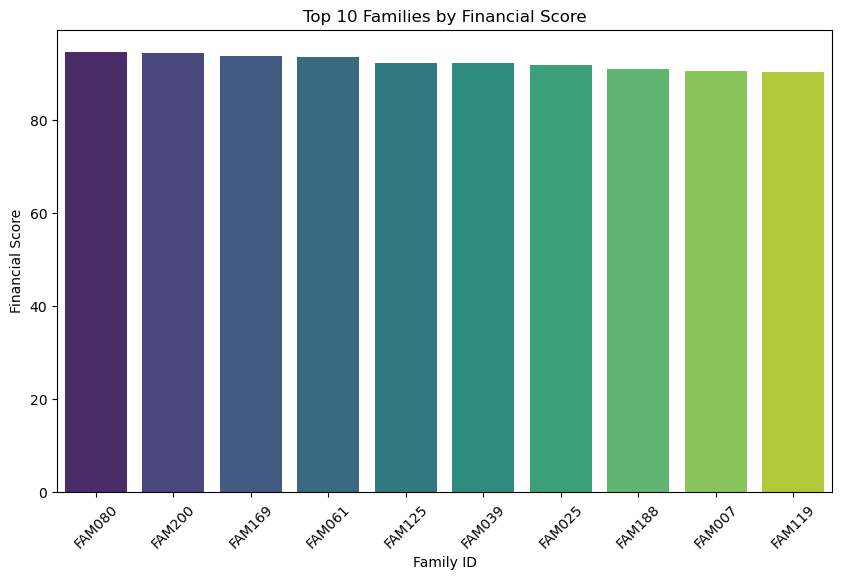

In [162]:
# Top N families
top_n = 10
top_families = family_scores_sorted.head(top_n)

# Bar plot for top families
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.barplot(x='Family ID', y='Financial Score', data=top_families, palette='viridis')
plt.title(f"Top {top_n} Families by Financial Score")
plt.xlabel("Family ID")
plt.ylabel("Financial Score")
plt.xticks(rotation=45)
plt.show()

# Identify Families with Low Scores

In [164]:
low_score_threshold = 50  # threshold
low_score_families = family_scores_sorted[family_scores_sorted['Financial Score'] < low_score_threshold]

print("Low-Scoring Families:")
print(low_score_families)

Low-Scoring Families:
Empty DataFrame
Columns: [Family ID, Income, Savings, Monthly Expenses, Loan Payments, Credit Card Spending, Financial Goals Met (%), Financial Score]
Index: []


In [165]:
#checking the minimum and maximum scores
print("Minimum Financial Score:", family_scores_sorted['Financial Score'].min())
print("Maximum Financial Score:", family_scores_sorted['Financial Score'].max())

Minimum Financial Score: 60.47
Maximum Financial Score: 94.57


In [166]:
low_score_threshold = 70  # threshold
low_score_families = family_scores_sorted[family_scores_sorted['Financial Score'] < low_score_threshold]

print("Low-Scoring Families:")
print(low_score_families)

Low-Scoring Families:
    Family ID    Income  Savings  Monthly Expenses  Loan Payments  \
67     FAM068   8393274  1289450            250674         213118   
17     FAM018   2699035  1108765            283610         392551   
68     FAM069   7390116   561168            152928         391500   
41     FAM042   5041674   914859            629343         369270   
48     FAM049   9235112  2526251            131208         141858   
..        ...       ...      ...               ...            ...   
27     FAM028   3715500    68280            154320          69720   
195    FAM196   8056652   446896            438092          77128   
151    FAM152  14168817   126651            412032         413364   
174    FAM175   9902606   317164            503644         287046   
76     FAM077   5741112   152984            215384         220792   

     Credit Card Spending  Financial Goals Met (%)  Financial Score  
67                 139810                     68.0            69.90  
17       

# Adding Recommendations to the Dataset

In [168]:
def provide_recommendations(row):
    if row['Monthly Expenses'] / row['Income'] > 0.5:
        return "Reduce monthly expenses to below 50% of income."
    elif row['Savings'] / row['Income'] < 0.2:
        return "Increase savings to at least 20% of income."
    elif row['Loan Payments'] / row['Income'] > 0.3:
        return "Reduce loan payments to below 30% of income."
    else:
        return "Maintain current habits and track spending."

family_scores_sorted['Recommendations'] = family_scores_sorted.apply(provide_recommendations, axis=1)

# Display a sample of recommendations
print(family_scores_sorted[['Family ID', 'Financial Score', 'Recommendations']].head())

    Family ID  Financial Score                              Recommendations
79     FAM080            94.57  Maintain current habits and track spending.
199    FAM200            94.37  Maintain current habits and track spending.
168    FAM169            93.69  Maintain current habits and track spending.
60     FAM061            93.41  Maintain current habits and track spending.
124    FAM125            92.22  Maintain current habits and track spending.


# Building a API

In [170]:
#Still not learnt

# Spending to income ratio distribution

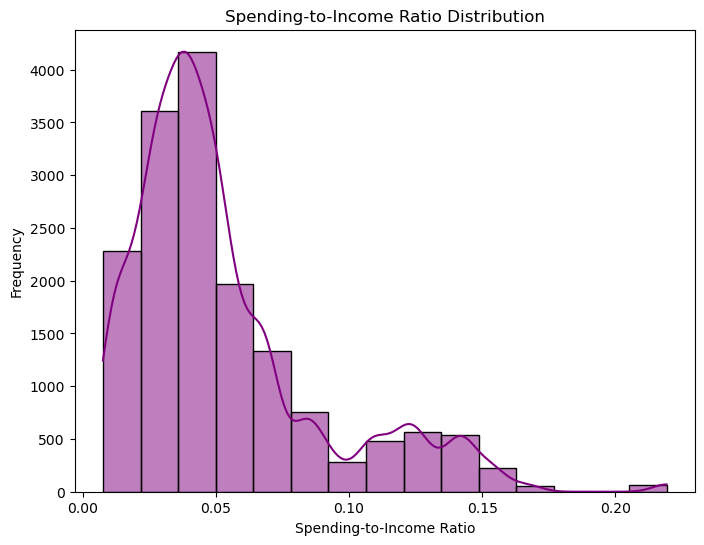

In [205]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Monthly Expenses'] / df['Income'], kde=True, bins=15, color='purple')
plt.title("Spending-to-Income Ratio Distribution")
plt.xlabel("Spending-to-Income Ratio")
plt.ylabel("Frequency")
plt.show()